In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification

In [77]:
df = pd.read_csv("train_df_clean.csv")

Q1:

In [78]:
def visualize_clf(clf, X, Y, title, marker_size=250):
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["P", "v"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())
    plot_step = 0.02

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(range(n_classes), palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()

In [79]:
X_toy, y_toy = make_classification(n_samples=100, n_features=2,
                                   random_state=16, flip_y = 0.1,
                                   n_informative=2, n_redundant=0)

Q2:

In [80]:
# Computes the correlation between spread  and the rest of the features

s = df.corr().spread.abs()
s.sort_values(kind="quicksort", ascending=False)

spread              1.000000
PCR_10              0.212723
PCR_07              0.042114
blood_A_AB          0.037510
PCR_01              0.022668
PCR_06              0.020925
covid               0.014039
PCR_02              0.013176
num_of_siblings     0.010719
household_income    0.008204
PCR_03              0.003534
risk                0.000343
sugar_levels        0.000150
Name: spread, dtype: float64

Q3:

Text(0.5, 0, 'PCR_10')

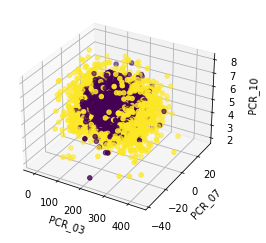

In [81]:
# Creates a 3d scatter plot of PCR_03, PCR_07, and PCR_10 with regards to spread

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(df.PCR_03, df.PCR_07, df.PCR_10, c=df.spread, marker='o')

ax.set_xlabel('PCR_03')
ax.set_ylabel('PCR_07')
ax.set_zlabel('PCR_10')
